# Convolution

In [1]:
import datetime
import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.2470, 0.2435, 0.2616)),
])

In [3]:
cifar10 = datasets.CIFAR10("data/", train=True, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, transform=transform)

In [4]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [5]:
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [6]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

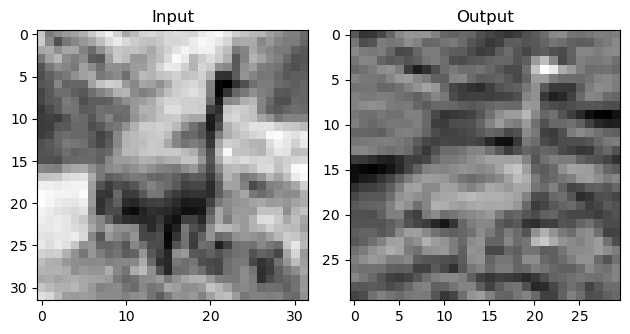

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(img[0], cmap="gray")
axs[1].imshow(output[0, 0].detach(), cmap="gray")

axs[0].set_title("Input")
axs[1].set_title("Output")

plt.tight_layout()
plt.show()

## Kernels

In [9]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [10]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

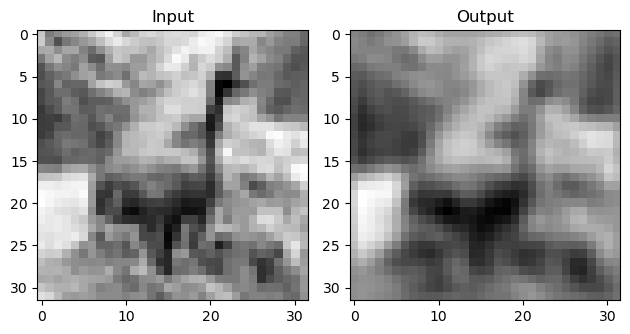

In [11]:
output = conv(img.unsqueeze(0))

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(img[0], cmap="gray")
axs[1].imshow(output[0, 0].detach(), cmap="gray")

axs[0].set_title("Input")
axs[1].set_title("Output")

plt.tight_layout()
plt.show()

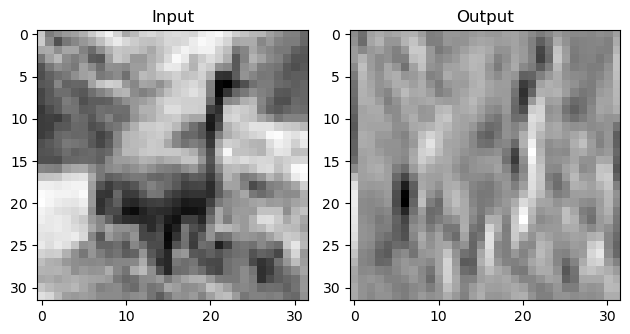

In [12]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))

fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(img[0], cmap="gray")
axs[1].imshow(output[0, 0].detach(), cmap="gray")

axs[0].set_title("Input")
axs[1].set_title("Output")

plt.tight_layout()
plt.show()

## Downsampling

In [13]:
pool = nn.MaxPool2d(kernel_size=2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## Convolutional Neural Network

In [14]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=8 * 8 * 8, out_features=32),
    nn.Tanh(),
    nn.Linear(in_features=32, out_features=2),
)

In [15]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [16]:
model(img.unsqueeze(0))

tensor([[ 0.1498, -0.0625]], grad_fn=<AddmmBackward0>)

## Custom Submodule

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [18]:
model = Net()

In [19]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## Functional API

In [20]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [21]:
model = Net()

In [22]:
model(img.unsqueeze(0))

tensor([[-0.1304, -0.1244]], grad_fn=<AddmmBackward0>)

## Model Training

In [23]:
def train(n_epochs, model, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0

        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            average_loss = training_loss / len(train_loader)
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [24]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

In [25]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [26]:
train(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2024-08-21 20:45:59.719009 Epoch: 1, Training loss: 0.5469
2024-08-21 20:46:05.244161 Epoch: 10, Training loss: 0.3326
2024-08-21 20:46:11.180636 Epoch: 20, Training loss: 0.2959
2024-08-21 20:46:17.180058 Epoch: 30, Training loss: 0.2696
2024-08-21 20:46:23.073631 Epoch: 40, Training loss: 0.2474
2024-08-21 20:46:29.025723 Epoch: 50, Training loss: 0.2332
2024-08-21 20:46:34.943090 Epoch: 60, Training loss: 0.2134
2024-08-21 20:46:40.842697 Epoch: 70, Training loss: 0.2004
2024-08-21 20:46:46.741630 Epoch: 80, Training loss: 0.1846
2024-08-21 20:46:53.722438 Epoch: 90, Training loss: 0.1724
2024-08-21 20:47:01.178831 Epoch: 100, Training loss: 0.1586


## Measuring Accuracy

In [32]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [34]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, dim=1)
                total += targets.shape[0]
                correct += int((predictions == targets).sum())

        accuracy = (correct / total) * 100
        print(f"{name} accuracy: {accuracy:.2f}%")

In [35]:
validate(model, train_loader, val_loader)

Training accuracy: 92.99%
Validation accuracy: 90.05%


## Saving Model

In [36]:
torch.save(model.state_dict(), "data/cifar2.pt")

In [37]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("data/cifar2.pt"))

<All keys matched successfully>

## Training on GPU

In [38]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device: {device}")

Training on device: cpu


In [39]:
def train(n_epochs, model, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device=device)
            targets = targets.to(device=device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            average_loss = training_loss / len(train_loader)
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [40]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

In [41]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

In [42]:
train(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

2024-07-25 19:33:02.293235 Epoch: 1, Training loss: 0.5928
2024-07-25 19:33:30.655568 Epoch: 10, Training loss: 0.3448
2024-07-25 19:34:01.214162 Epoch: 20, Training loss: 0.2998
2024-07-25 19:34:36.560403 Epoch: 30, Training loss: 0.2732
2024-07-25 19:35:06.156348 Epoch: 40, Training loss: 0.2471
2024-07-25 19:35:36.708380 Epoch: 50, Training loss: 0.2248
2024-07-25 19:36:05.614502 Epoch: 60, Training loss: 0.2058
2024-07-25 19:36:36.083663 Epoch: 70, Training loss: 0.1932
2024-07-25 19:37:06.675339 Epoch: 80, Training loss: 0.1781
2024-07-25 19:37:43.329905 Epoch: 90, Training loss: 0.1648
2024-07-25 19:38:18.340637 Epoch: 100, Training loss: 0.1523


In [49]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [50]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                _, predictions = torch.max(outputs, dim=1)
                total += targets.shape[0]
                correct += int((predictions == targets).sum())

        accuracy = (correct / total) * 100
        print(f"{name} accuracy: {accuracy:.2f}%")

In [51]:
validate(model, train_loader, val_loader)

Training accuracy: 83.82%
Validation accuracy: 80.75%


In [47]:
torch.save(model.state_dict(), "data/cifar2.pt")

In [48]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load("data/cifar2.pt", map_location=device))

<All keys matched successfully>

## Wider Network

In [52]:
class NetWidth(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = NetWidth()

sum(p.numel() for p in model.parameters())

38386

## Weight Decay

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [56]:
def training_with_weight_decay(n_epochs, model, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0

        for inputs, targets in train_loader:
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            alpha = 1e-3
            # l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + alpha * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            average_loss = training_loss / len(train_loader)
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [57]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train(10, model, optimizer, loss_fn, train_loader)

2024-07-25 21:37:49.948335 Epoch: 1, Training loss: 0.4246
2024-07-25 21:38:18.805210 Epoch: 10, Training loss: 0.3421


In [58]:
def training_with_builtin_weight_decay(n_epochs, model, optimizer, loss_fn, train_loader):
     for epoch in range(1, n_epochs + 1):
        training_loss = 0.0

        for inputs, targets in train_loader:
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            average_loss = training_loss / len(train_loader)
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [59]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.5)
loss_fn = nn.CrossEntropyLoss()

train(10, model, optimizer, loss_fn, train_loader)

2024-07-25 21:42:55.403503 Epoch: 1, Training loss: 0.6771
2024-07-25 21:43:30.143541 Epoch: 10, Training loss: 0.5734


## Dropout

In [60]:
class NetDropout(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_channels1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [61]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()

train(10, model, optimizer, loss_fn, train_loader)

2024-07-25 21:49:08.333949 Epoch: 1, Training loss: 0.5706
2024-07-25 21:49:34.377883 Epoch: 10, Training loss: 0.3271


## Batch Normalization

In [70]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_channels1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_channels // 2)
        self.fc1 = nn.Linear(8 * 8 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_channels1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [71]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

model.train()

train(10, model, optimizer, loss_fn, train_loader)

2024-07-25 22:03:35.108039 Epoch: 1, Training loss: 0.5871
2024-07-25 22:04:01.659310 Epoch: 10, Training loss: 0.3318


## Deeper Networks

In [72]:
class NetDepth(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_channels1 // 2, n_channels1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_channels1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Skip Connections

In [73]:
class NetRes(nn.Module):
    def __init__(self, n_channels1=32):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels1, n_channels1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_channels1 // 2, n_channels1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_channels1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_channels1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

## Very Deep Networks

In [7]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_channels)
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity="relu")
        nn.init.constant_(self.batch_norm.weight, 0.5)
        nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [8]:
class NetResDeep(nn.Module):
    def __init__(self, n_channels1=32, n_blocks=10):
        super().__init__()
        self.n_channels1 = n_channels1
        self.conv1 = nn.Conv2d(3, n_channels1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_channels=n_channels1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_channels1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_channels1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [12]:
def train(n_epochs, model, optimizer, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0

        for inputs, targets in train_loader:
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            average_loss = training_loss / len(train_loader)
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [13]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

model = NetResDeep().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

model.train()

train(10, model, optimizer, loss_fn, train_loader)

2024-07-25 23:33:11.706744 Epoch: 1, Training loss: 0.5020
2024-07-25 23:37:42.805976 Epoch: 10, Training loss: 0.2529


In [14]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                _, predictions = torch.max(outputs, dim=1)
                total += targets.shape[0]
                correct += int((predictions == targets).sum())

        accuracy = (correct / total) * 100
        print(f"{name} accuracy: {accuracy:.2f}%")

In [16]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [17]:
validate(model, train_loader, val_loader)

Training accuracy: 89.91%
Validation accuracy: 86.85%


## Exercises

In [125]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

### Kernel Size

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.2470, 0.2435, 0.2616)),
])

In [3]:
cifar10 = datasets.CIFAR10("data/", train=True, download=False, transform=transform)
cifar10_val = datasets.CIFAR10("data/", train=False, download=False, transform=transform)

In [4]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [23]:
def train(n_epochs, model, optimizer, loss_fn, train_loader, device):
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        average_loss = training_loss / len(train_loader)
        if epoch == 1 or epoch % 10 == 0:
            print(f"{datetime.datetime.now()} Epoch: {epoch}, Training loss: {average_loss:.4f}")

In [25]:
"""
Model Architecture:
    conv -> relu -> maxpool -> conv -> relu -> maxpool -> flatten -> linear -> relu -> linear

Input shapes:
    (x)   -> N, 3, 32, 32  -> (conv1) -> N, 16, 32, 32 -> (relu) -> N, 16, 32, 32 -> (maxpool) -> N, 16, 16, 16 -> (out)
    (out) -> N, 16, 16, 16 -> (conv2) -> N, 8, 16, 16  -> (relu) -> N, 8, 16, 16  -> (maxpool) -> N, 8, 8, 8    -> (out)
    (out) -> N, 8, 8, 8    -> (view)  -> N, 8 * 8 * 8  -> (out)
    (out) -> N, 8 * 8 * 8  -> (fc1)   -> N, 32         -> (relu) -> N, 32 -> (out)
    (out) -> N, 32         -> (fc2)   -> N, 2          -> (out)
"""

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

In [27]:
model.train()

train(100, model, optimizer, loss_fn, train_loader, device)

2024-07-27 20:12:54.409695 Epoch: 1, Training loss: 0.6182
2024-07-27 20:13:35.514174 Epoch: 10, Training loss: 0.3115
2024-07-27 20:14:27.250976 Epoch: 20, Training loss: 0.2594
2024-07-27 20:15:24.106586 Epoch: 30, Training loss: 0.2261
2024-07-27 20:16:12.634897 Epoch: 40, Training loss: 0.2056
2024-07-27 20:17:03.342605 Epoch: 50, Training loss: 0.1771
2024-07-27 20:17:53.694665 Epoch: 60, Training loss: 0.1543
2024-07-27 20:18:41.554367 Epoch: 70, Training loss: 0.1355
2024-07-27 20:19:27.196931 Epoch: 80, Training loss: 0.1116
2024-07-27 20:20:12.071627 Epoch: 90, Training loss: 0.0927
2024-07-27 20:20:56.989218 Epoch: 100, Training loss: 0.0755


In [28]:
numel_list = [p.numel() for p in model.parameters()]
print(f"Total parameters: {sum(numel_list)}")
print(f"Parameters in each submodule: {numel_list}")

Total parameters: 20906
Parameters in each submodule: [1200, 16, 3200, 8, 16384, 32, 64, 2]


In [35]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [36]:
simplemodel = SimpleNet().to(device)

numel_list = [p.numel() for p in simplemodel.parameters()]
print(f"Total parameters: {sum(numel_list)}")
print(f"Parameters in each submodule: {numel_list}")

Total parameters: 18090
Parameters in each submodule: [432, 16, 1152, 8, 16384, 32, 64, 2]


In [43]:
def evaluate(model, train_loader, val_loader, device):
    data_loaders = [("Training", train_loader), ("Validation", val_loader)]

    for name, data_loader in data_loaders:
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                _, predictions = torch.max(outputs, dim=1)
                correct += int((predictions == targets).sum())
                total += targets.shape[0]

        accuracy = (correct / total) * 100
        print(f"{name} accuracy: {accuracy:.2f}%")

In [44]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [52]:
model.eval()

evaluate(model, train_loader, val_loader, device)

Training accuracy: 97.57%
Validation accuracy: 89.15%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


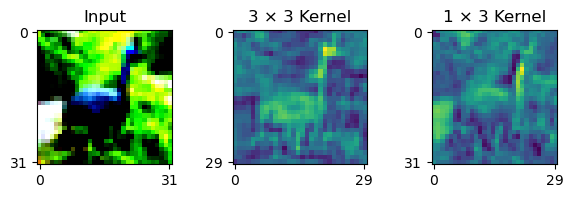

In [71]:
img, _ = cifar2[0]

sq_conv = nn.Conv2d(3, 1, kernel_size=(3, 3))
rect_conv = nn.Conv2d(3, 1, kernel_size=(1, 3))
sq_out = sq_conv(img)
rect_out = rect_conv(img)

img = img.permute(1, 2, 0)
sq_out = sq_out.permute(1, 2, 0)
sq_out = sq_out.detach().numpy()
rect_out = rect_out.permute(1, 2, 0)
rect_out = rect_out.detach().numpy()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
ax1.imshow(p_image)
ax2.imshow(sq_out)
ax3.imshow(rect_out)
ax1.set_title("Input")
ax2.set_title("3 × 3 Kernel")
ax3.set_title("1 × 3 Kernel")
ax1.set_xticks([0, img.shape[1] - 1], [0, img.shape[1] - 1])
ax2.set_xticks([0, sq_out.shape[1] - 1], [0, sq_out.shape[1] - 1])
ax3.set_xticks([0, rect_out.shape[1] - 1], [0, rect_out.shape[1] - 1])
ax1.set_yticks([0, img.shape[0] - 1], [0, img.shape[0] - 1])
ax2.set_yticks([0, sq_out.shape[0] - 1], [0, sq_out.shape[0] - 1])
ax3.set_yticks([0, rect_out.shape[0] - 1], [0, rect_out.shape[0] - 1])
plt.tight_layout()
plt.savefig("data/kernel_sizes.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


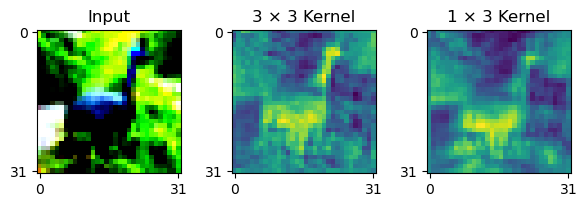

In [72]:
img, _ = cifar2[0]

sq_conv = nn.Conv2d(3, 1, kernel_size=(3, 3), padding="same")
rect_conv = nn.Conv2d(3, 1, kernel_size=(1, 3), padding="same")
sq_out = sq_conv(img)
rect_out = rect_conv(img)

img = img.permute(1, 2, 0)
sq_out = sq_out.permute(1, 2, 0)
sq_out = sq_out.detach().numpy()
rect_out = rect_out.permute(1, 2, 0)
rect_out = rect_out.detach().numpy()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))
ax1.imshow(img)
ax2.imshow(sq_out)
ax3.imshow(rect_out)
ax1.set_title("Input")
ax2.set_title("3 × 3 Kernel")
ax3.set_title("1 × 3 Kernel")
ax1.set_xticks([0, img.shape[1] - 1], [0, img.shape[1] - 1])
ax2.set_xticks([0, sq_out.shape[1] - 1], [0, sq_out.shape[1] - 1])
ax3.set_xticks([0, rect_out.shape[1] - 1], [0, rect_out.shape[1] - 1])
ax1.set_yticks([0, img.shape[0] - 1], [0, img.shape[0] - 1])
ax2.set_yticks([0, sq_out.shape[0] - 1], [0, sq_out.shape[0] - 1])
ax3.set_yticks([0, rect_out.shape[0] - 1], [0, rect_out.shape[0] - 1])
plt.tight_layout()
plt.show()

In [78]:
"""
Model Architecture:
    conv -> relu -> maxpool -> conv -> relu -> maxpool -> flatten -> linear -> relu -> linear

Input shapes:
    (x)   -> N, 3, 32, 32  -> (conv1) -> N, 16, 32, 32 -> (relu) -> N, 16, 32, 32 -> (maxpool) -> N, 16, 16, 16 -> (out)
    (out) -> N, 16, 16, 16 -> (conv2) -> N, 8, 16, 16  -> (relu) -> N, 8, 16, 16  -> (maxpool) -> N, 8, 8, 8    -> (out)
    (out) -> N, 8, 8, 8    -> (view)  -> N, 8 * 8 * 8  -> (out)
    (out) -> N, 8 * 8 * 8  -> (fc1)   -> N, 32         -> (relu) -> N, 32 -> (out)
    (out) -> N, 32         -> (fc2)   -> N, 2          -> (out)
"""

class WierdNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=(1, 3), padding="same")
        self.conv2 = nn.Conv2d(16, 8, kernel_size=(1, 3), padding="same")
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WierdNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

In [80]:
model.train()

train(100, model, optimizer, loss_fn, train_loader, device)

2024-07-27 23:29:39.965348 Epoch: 1, Training loss: 0.6809
2024-07-27 23:30:02.650512 Epoch: 10, Training loss: 0.3783
2024-07-27 23:30:26.920848 Epoch: 20, Training loss: 0.3384
2024-07-27 23:30:54.967366 Epoch: 30, Training loss: 0.3118
2024-07-27 23:31:27.444418 Epoch: 40, Training loss: 0.2931
2024-07-27 23:31:57.607350 Epoch: 50, Training loss: 0.2783
2024-07-27 23:32:24.759432 Epoch: 60, Training loss: 0.2613
2024-07-27 23:32:54.549558 Epoch: 70, Training loss: 0.2444
2024-07-27 23:33:34.430767 Epoch: 80, Training loss: 0.2265
2024-07-27 23:33:58.413573 Epoch: 90, Training loss: 0.2145
2024-07-27 23:34:43.715789 Epoch: 100, Training loss: 0.1916


In [81]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [82]:
model.eval()

evaluate(model, train_loader, val_loader, device)

Training accuracy: 92.61%
Validation accuracy: 88.20%


### Over-Generalization

In [148]:
model.eval()

for idx, (img, label) in enumerate(cifar10):
    if label not in [0, 2]:
        with torch.no_grad():
            out = model(img)
            confidences = F.softmax(out, dim=1)
            confidences = confidences.detach().numpy()[0]
            if (confidences[0] > 0.95) or (confidences[1] > 0.95):
                print(f"Index: {idx}")
                break

Index: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth: deer
Confidence for airplane: 4.33%
Confidence for bird: 95.67%


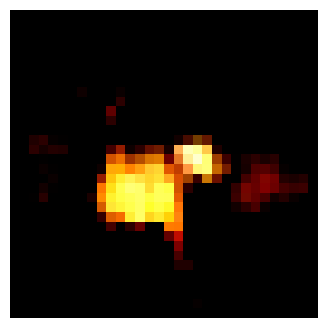

In [149]:
model.eval()
img, label = cifar10[idx]

with torch.no_grad():
    out = model(img)
    confidences = F.softmax(out, dim=1)
    confidences = confidences.detach().numpy()[0]
    print(f"Ground truth: {cifar10.classes[label]}")
    print(f"Confidence for airplane: {confidences[0] * 100:.2f}%")
    print(f"Confidence for bird: {confidences[1] * 100:.2f}%")

fig = plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.savefig("data/over-generalization.png")
plt.show()

In [150]:
model.eval()

for idx, (img, label) in enumerate(cifar10):
    if label not in [0, 2]:
        with torch.no_grad():
            out = model(img)
            confidences = F.softmax(out, dim=1)
            confidences = confidences.detach().numpy()[0]
            if (0.45 <= confidences[0] <= 0.55):
                print(f"Index: {idx}")
                break

Index: 20


Ground truth: deer
Confidence for airplane: 52.33%
Confidence for bird: 47.67%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


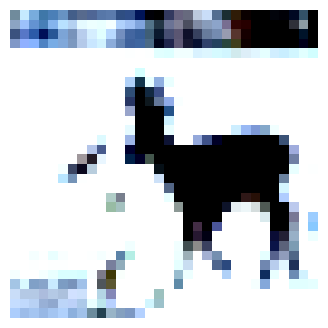

In [151]:
model.eval()
img, label = cifar10[idx]

with torch.no_grad():
    out = model(img)
    confidences = F.softmax(out, dim=1)
    confidences = confidences.detach().numpy()[0]
    print(f"Ground truth: {cifar10.classes[label]}")
    print(f"Confidence for airplane: {confidences[0] * 100:.2f}%")
    print(f"Confidence for bird: {confidences[1] * 100:.2f}%")

fig = plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [152]:
cifar10_original = datasets.CIFAR10("data/", train=True, download=False)

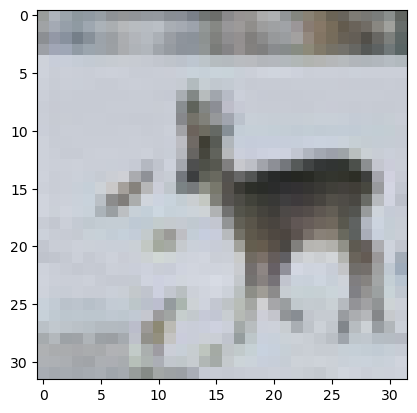

In [153]:
img, _ = cifar10_original[idx]
img.save("data/neutral.png")
plt.imshow(img)
plt.show()

In [154]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.2470, 0.2435, 0.2616)),
])

img = Image.open("data/neutral-modified.png")
img = transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confidence for airplane: 86.92%
Confidence for bird: 13.08%


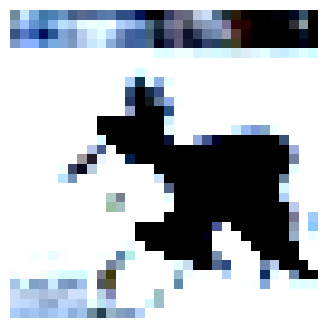

In [155]:
with torch.no_grad():
    out = model(img)
    confidences = F.softmax(out, dim=1)
    confidences = confidences.detach().numpy()[0]
    print(f"Confidence for airplane: {confidences[0] * 100:.2f}%")
    print(f"Confidence for bird: {confidences[1] * 100:.2f}%")

fig = plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [170]:
for idx, (img, label) in enumerate(cifar10):
    if label == 0:
        print(f"Index: {idx}")
        break

Index: 29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground truth: airplane
Confidence for airplane: 94.10%
Confidence for bird: 5.90%


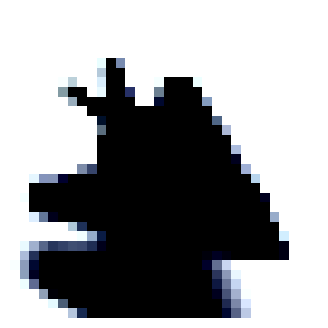

In [171]:
model.eval()
img, label = cifar10[idx]

with torch.no_grad():
    out = model(img)
    confidences = F.softmax(out, dim=1)
    confidences = confidences.detach().numpy()[0]
    print(f"Ground truth: {cifar10.classes[label]}")
    print(f"Confidence for airplane: {confidences[0] * 100:.2f}%")
    print(f"Confidence for bird: {confidences[1] * 100:.2f}%")

fig = plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

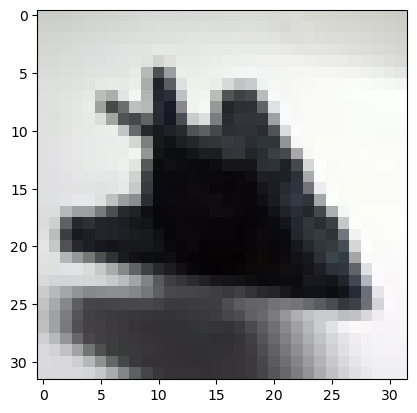

In [172]:
img, _ = cifar10_original[idx]
img.save("data/airplane.png")
plt.imshow(img)
plt.show()

In [173]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.2470, 0.2435, 0.2616)),
])

img = Image.open("data/airplane-modified.png")
img = transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confidence for airplane: 2.60%
Confidence for bird: 97.40%


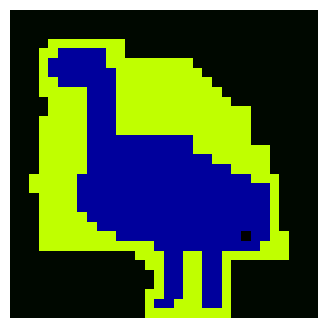

In [174]:
with torch.no_grad():
    out = model(img)
    confidences = F.softmax(out, dim=1)
    confidences = confidences.detach().numpy()[0]
    print(f"Confidence for airplane: {confidences[0] * 100:.2f}%")
    print(f"Confidence for bird: {confidences[1] * 100:.2f}%")

fig = plt.figure(figsize=(4, 4))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.show()

Index: 6


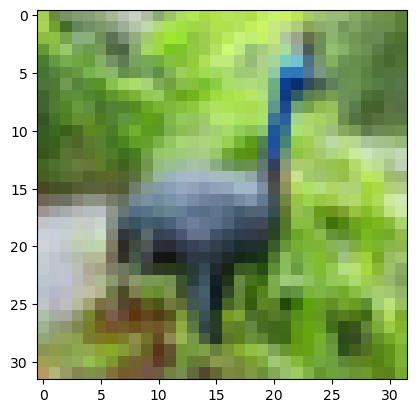

In [175]:
for idx, (img, label) in enumerate(cifar10):
    if label == 2:
        print(f"Index: {idx}")
        break

img, _ = cifar10_original[idx]
img.save("data/bird.png")
plt.imshow(img)
plt.show()